In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf
import utils.eval_metrics as em
from tslearn.clustering import TimeSeriesKMeans

utils.py Loading


In [14]:
small = False # True for small dataset, False for big dataset


data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

if small:
    all_groups = ["PAK", "SDN", "BDI", "HTI","EST", "CZE", "MLT", "SGP", "IRL", "CHE", "ISL", "NZL", "SWE"]
    data = data.loc[all_groups]
    title_prefix = "Small "
else:
    title_prefix = "Big "

N = data.index.shape[0]

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

Weight_vector = [1/L for _ in range(L)] # Equal weights times

alternatives = data.index # Alternatives are the countries

phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023)) # Transform PHI into a dataframe with ISO3 as index and years as columns


eta = pf.get_eta_matrix(data, phi_c_all, W, L)
agg_eta = pf.aggregate_all_series(eta, Weight_vector)
dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

# Transform phi_c_all into a dataframe with ISO3 and variable names as columns (each cell is a np.array)
phi_c_all = np.array(phi_c_all)
variable_names = data.columns
phi_c_all_df = pd.DataFrame(index=alternatives, columns=variable_names)
for i in range(K):
    phi_c_all_df[variable_names[i]] = [phi_c_all[i][j] for j in range(N)]

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


In [15]:
def get_n_P2Kmeans_results(n_samples, PHI_df, k, random_init=True, dist_measure=cf.euclid_distance):
    """
    Run KMeans clustering on the data and return the labels and inertia.
    """
    all_clusterings = []
    for i in tqdm(range(n_samples)):
        results = cf.kMeans(PHI_df, k, max_it=50, distance_function=dist_measure, random_selec=random_init)

        # Get a list of list of ISO3 codes for each cluster
        clusters = []
        for i in range(k):
            clusters.append(results[i].index.tolist())
        
        all_clusterings.append(clusters)
    return all_clusterings


In [16]:
def compare_params_P2Kmeans(n_samples, PHI_df, k):
    euclid_random = get_n_P2Kmeans_results(n_samples, PHI_df, k, random_init=True, dist_measure=cf.euclid_distance)
    euclid_no_random = get_n_P2Kmeans_results(n_samples, PHI_df, k, random_init=False, dist_measure=cf.euclid_distance)
    dtw_random = get_n_P2Kmeans_results(n_samples, PHI_df, k, random_init=True, dist_measure=cf.dynamic_time_warping)
    dtw_no_random = get_n_P2Kmeans_results(n_samples, PHI_df, k, random_init=False, dist_measure=cf.dynamic_time_warping)

    return euclid_random, euclid_no_random, dtw_random, dtw_no_random

In [17]:
def evaluate_params(euclid_random, euclid_no_random, dtw_random, dtw_no_random, data, method=em.evaluate_silhouette_on_data):
    """
    Evaluate the clustering results using different metrics.
    """
    # Evaluate the clustering results using different metrics
    euclid_random_score = np.array(method(euclid_random, data))
    euclid_no_random_score = np.array(method(euclid_no_random, data))
    dtw_random_score = np.array(method(dtw_random, data))
    dtw_no_random_score = np.array(method(dtw_no_random, data))

    return euclid_random_score, euclid_no_random_score, dtw_random_score, dtw_no_random_score

def plot_scores(euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn, title="Silhouette Index"):
    """
    Plot the Dunn index for each clustering method.
    Using boxplots to show the distribution of the Dunn index for each method.
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot([euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn], 
                labels=["Euclid Random", "Euclid km++", "DTW Random", "DTW km++"])
    plt.title(f"{title} for P2KMeans Clustering")
    plt.ylabel(title)
    plt.xlabel("Clustering Method")
    plt.show()

In [18]:
k = 5 # Number of clusters
n_samples = 20 # Number of samples to run

euclid_random, euclid_no_random, dtw_random, dtw_no_random = compare_params_P2Kmeans(n_samples, PHI_df, k)

100%|██████████| 20/20 [09:58<00:00, 29.95s/it]


C:\Users\raphu\AppData\Local\Temp\ipykernel_35184\3996549428.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn],


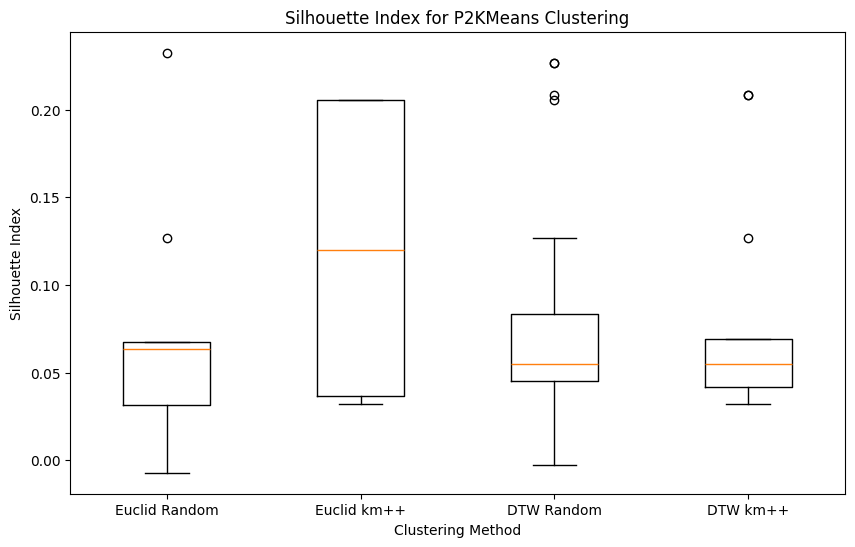

In [19]:
euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn = evaluate_params(euclid_random, euclid_no_random, dtw_random, dtw_no_random, data)
plot_scores(euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn)

C:\Users\raphu\AppData\Local\Temp\ipykernel_35184\3996549428.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn],


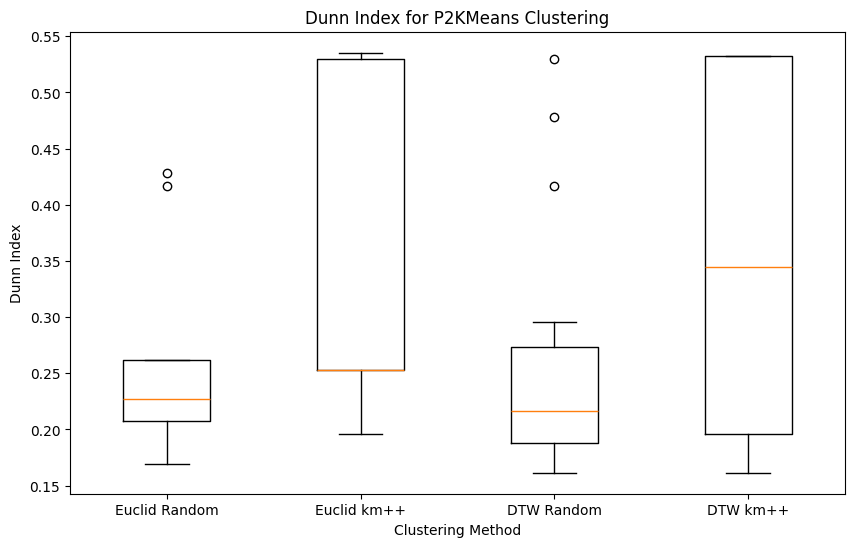

In [20]:
euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn = evaluate_params(euclid_random, euclid_no_random, dtw_random, dtw_no_random, data, method=em.evaluate_results_on_data)
plot_scores(euclid_random_dunn, euclid_no_random_dunn, dtw_random_dunn, dtw_no_random_dunn, title="Dunn Index")